# RAMP on predicting cyclist traffic in Paris

Authors: *Roman Yurchak (Symerio)*; also partially inspired by the air_passengers starting kit.


## Introduction

The dataset was collected with cyclist counters installed by Paris city council in multiple locations. It contains hourly information about cyclist traffic, as well as the following features,
 - counter name
 - counter site name
 - date
 - counter installation date
 - latitude and longitude
 
Available features are quite scarce. However, **we can also use any external data that can help us to predict the target variable.** 

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

# Loading the data with pandas

First, download the data files,
 - [train.parquet](https://github.com/rth/bike_counters/releases/download/v0.1.0/train.parquet)
 - [test.parquet](https://github.com/rth/bike_counters/releases/download/v0.1.0/test.parquet)

and put them to into the data folder.


Data is stored in [Parquet format](https://parquet.apache.org/), an efficient columnar data format. We can load the train set with pandas,

In [2]:
data = pd.read_parquet(Path("data") / "train.parquet")

In [3]:
data.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.693147
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,1.609438
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,2.302585


We can check general information about different columns,

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 455163 entries, 48321 to 928462
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   counter_id                 455163 non-null  category      
 1   counter_name               455163 non-null  category      
 2   site_id                    455163 non-null  int64         
 3   site_name                  455163 non-null  category      
 4   bike_count                 455163 non-null  float64       
 5   date                       455163 non-null  datetime64[ns]
 6   counter_installation_date  455163 non-null  datetime64[ns]
 7   counter_technical_id       455163 non-null  category      
 8   latitude                   455163 non-null  float64       
 9   longitude                  455163 non-null  float64       
 10  log_bike_count             455163 non-null  float64       
dtypes: category(4), datetime64[ns](2), float64(4), i

and in particular the number of unique entries in each column,

In [5]:
data.nunique(axis=0)

counter_id                     56
counter_name                   56
site_id                        30
site_name                      30
bike_count                    977
date                         8230
counter_installation_date      22
counter_technical_id           30
latitude                       30
longitude                      30
log_bike_count                977
dtype: int64

We have a 30 counting sites where sometimes multiple counters are installed per location.  Let's look at the most frequented stations,

In [6]:
data.groupby(["site_name", "counter_name"])["bike_count"].sum().sort_values(
    ascending=False
).head(10).to_frame()

,,bike_count
site_name,counter_name,
Totem 73 boulevard de Sébastopol,Totem 73 boulevard de Sébastopol S-N,1809231.0
Totem 64 Rue de Rivoli,Totem 64 Rue de Rivoli O-E,1406900.0
Totem 73 boulevard de Sébastopol,Totem 73 boulevard de Sébastopol N-S,1357868.0
67 boulevard Voltaire SE-NO,67 boulevard Voltaire SE-NO,1036575.0
Totem 64 Rue de Rivoli,Totem 64 Rue de Rivoli E-O,914089.0
27 quai de la Tournelle,27 quai de la Tournelle SE-NO,888717.0
Quai d'Orsay,Quai d'Orsay E-O,849724.0
Totem Cours la Reine,Totem Cours la Reine O-E,806149.0
Face au 48 quai de la marne,Face au 48 quai de la marne SO-NE,806071.0


# Visualizing the data


Let's visualize the data, starting from the spatial distribution of counters on the map

In [7]:
import folium

m = folium.Map(location=data[["latitude", "longitude"]].mean(axis=0), zoom_start=13)

for _, row in (
    data[["counter_name", "latitude", "longitude"]]
    .drop_duplicates("counter_name")
    .iterrows()
):
    folium.Marker(
        row[["latitude", "longitude"]].values.tolist(), popup=row["counter_name"]
    ).add_to(m)

m

Note that in this RAMP problem we consider only the 30 most frequented counting sites, to limit data size.


Next we will look into the temporal distribution of the most frequented bike counter. If we plot it directly we will not see much because there are half a million data points,

<Axes: xlabel='date'>

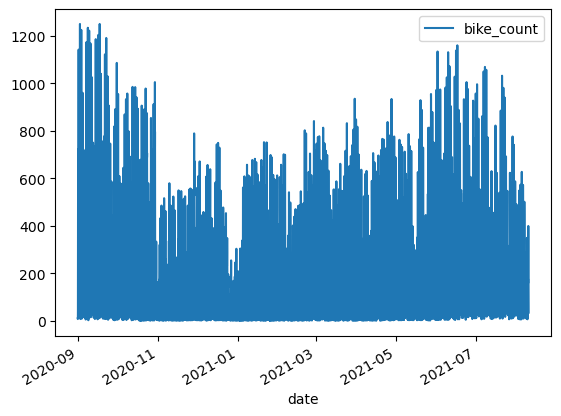

In [8]:
mask = data["counter_name"] == "Totem 73 boulevard de Sébastopol S-N"

data[mask].plot(x="date", y="bike_count")

Instead we aggregate the data, for instance, by week to have a clearer overall picture,

<Axes: xlabel='date'>

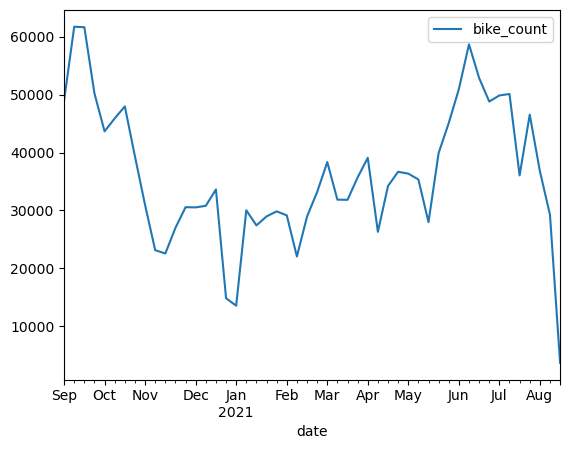

In [9]:
mask = data["counter_name"] == "Totem 73 boulevard de Sébastopol S-N"

data[mask].groupby(pd.Grouper(freq="1w", key="date"))[["bike_count"]].sum().plot()

While at the same time, we can zoom on a week in particular for a more short-term visualization,

<Axes: xlabel='date'>

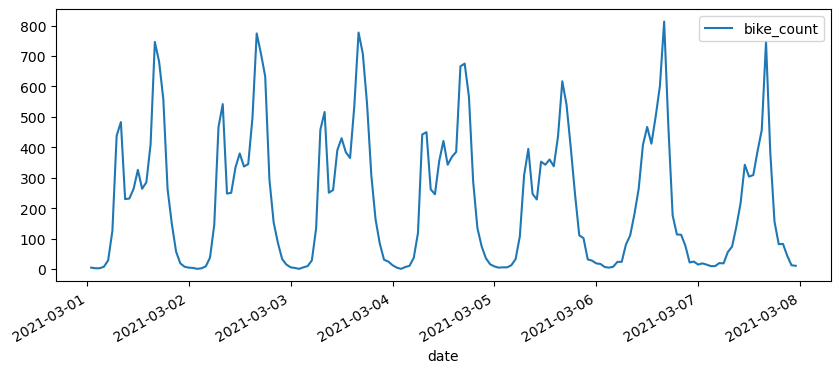

In [10]:
fig, ax = plt.subplots(figsize=(10, 4))

mask = (
    (data["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (data["date"] > pd.to_datetime("2021/03/01"))
    & (data["date"] < pd.to_datetime("2021/03/08"))
)

data[mask].plot(x="date", y="bike_count", ax=ax)

The hourly pattern has a clear variation between work days and weekends (7 and 8 March 2021).

If we look at the distribution of the target variable it skewed and non normal, 

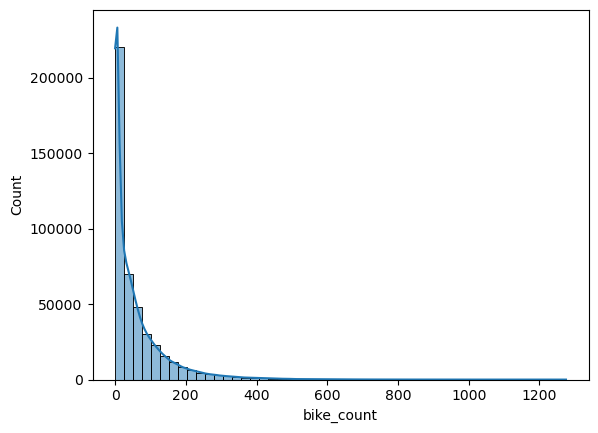

In [11]:
import seaborn as sns


ax = sns.histplot(data, x="bike_count", kde=True, bins=50)

Least square loss would not be appropriate to model it since it is designed for normal error distributions. One way to precede would be to transform the variable with a logarithmic transformation,
```py
data['log_bike_count'] = np.log(1 + data['bike_count'])
```

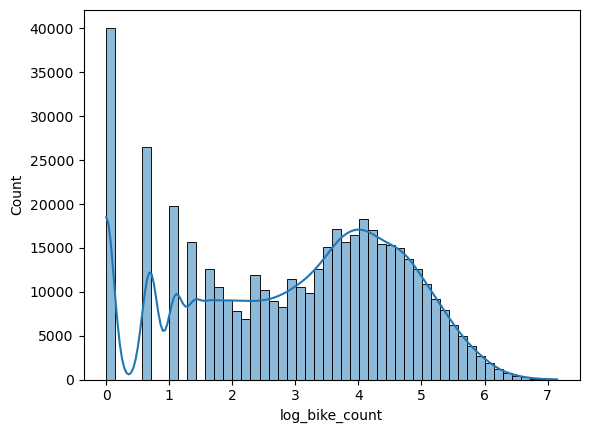

In [12]:
ax = sns.histplot(data, x="log_bike_count", kde=True, bins=50)

which has a more pronounced central mode, but is still non symmetric. In the following, **we use `log_bike_count` as the target variable** as otherwise `bike_count` ranges over 3 orders of magnitude and least square loss would be dominated by the few large values. 

## Feature extraction

To account for the temporal aspects of the data, we cannot input the `date` field directly into the model. Instead we extract the features on different time-scales from the `date` field, 

In [13]:
def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X.loc[:, "year"] = X["date"].dt.year
    X.loc[:, "month"] = X["date"].dt.month
    X.loc[:, "day"] = X["date"].dt.day
    X.loc[:, "weekday"] = X["date"].dt.weekday
    X.loc[:, "hour"] = X["date"].dt.hour

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"])

In [14]:
data["date"].head(10)

48321   2020-09-01 02:00:00
48324   2020-09-01 03:00:00
48327   2020-09-01 04:00:00
48330   2020-09-01 15:00:00
48333   2020-09-01 18:00:00
48336   2020-09-01 20:00:00
48339   2020-09-01 23:00:00
48342   2020-09-02 04:00:00
48345   2020-09-02 11:00:00
48348   2020-09-02 13:00:00
Name: date, dtype: datetime64[ns]

In [15]:
_encode_dates(data[["date"]].head())

,year,month,day,weekday,hour
48321,2020,9,1,1,2
48324,2020,9,1,1,3
48327,2020,9,1,1,4
48330,2020,9,1,1,15
48333,2020,9,1,1,18


To use this function with scikit-learn estimators we wrap it with [FunctionTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html),

In [16]:
from sklearn.preprocessing import FunctionTransformer

date_encoder = FunctionTransformer(_encode_dates, validate=False)
date_encoder.fit_transform(data[["date"]]).head()

,year,month,day,weekday,hour
48321,2020,9,1,1,2
48324,2020,9,1,1,3
48327,2020,9,1,1,4
48330,2020,9,1,1,15
48333,2020,9,1,1,18


Since it is unlikely that, for instance, that `hour` is linearly correlated with the target variable, we would need to additionally encode categorical features for linear models. This is classically done with [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), though other encoding strategies exist.

In [17]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse_output=False)

enc.fit_transform(_encode_dates(data[["date"]])[["hour"]].head())

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

## Matrice de correlation

C:\Users\charl\AppData\Local\Temp\ipykernel_13092\2784187003.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


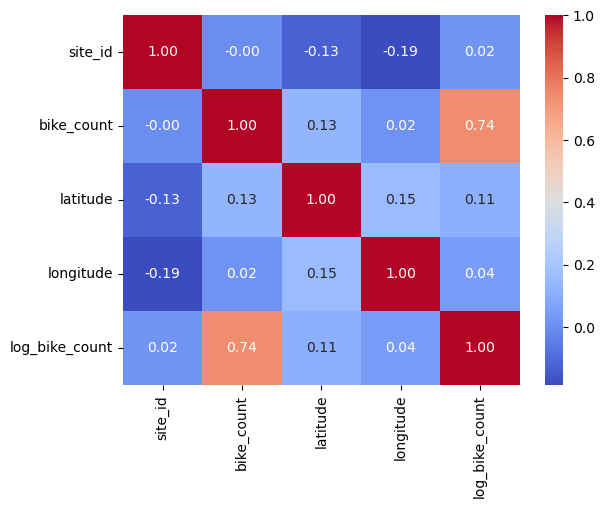

In [18]:
correlation_matrix = data.corr()
# Créer une carte thermique avec Seaborn
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")

# Afficher la carte thermique
plt.show()

## Analysons rapidos la donnée puisque l'on voit que l'on est au moment du covid et des confinements

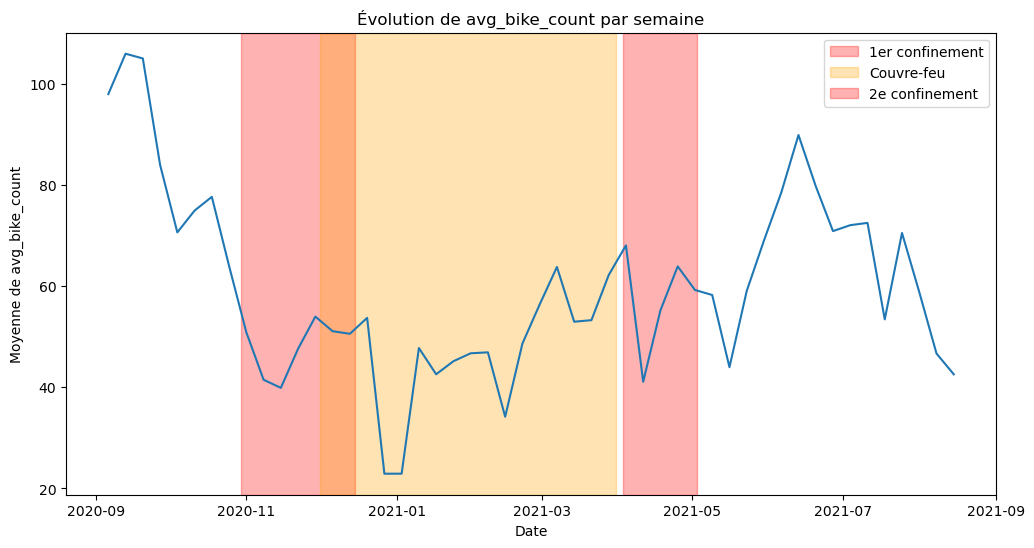

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Agrégation par semaine avec la moyenne
aggregated_data_weekly = data.resample('W', on='date').mean(numeric_only=True).reset_index()

# Tracer la série temporelle agrégée par semaine
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='bike_count', data=aggregated_data_weekly)

# Encadrement pour le 1er confinement (30 octobre 2020 - 15 décembre 2020)
plt.axvspan('2020-10-30', '2020-12-15', color='red', alpha=0.3, label='1er confinement')

# Encadrement pour le couvre-feu (Décembre 2020 - Mars 2021)
plt.axvspan('2020-12-01', '2021-03-31', color='orange', alpha=0.3, label='Couvre-feu')

# Encadrement pour le 2e confinement (3 avril 2021 - 3 mai 2021)
plt.axvspan('2021-04-03', '2021-05-03', color='red', alpha=0.3, label='2e confinement')

plt.title('Évolution de avg_bike_count par semaine')
plt.xlabel('Date')
plt.ylabel('Moyenne de avg_bike_count')
plt.legend()
plt.show()


## Je vais remplacer date par la data encodé plus clairement précédement 

In [20]:
_encode_dates(data[["date"]]).columns.tolist()

['year', 'month', 'day', 'weekday', 'hour']

In [21]:
df_encoded = _encode_dates(data[["date"]])
df = pd.concat([data, df_encoded], axis=1)

## Je vais regarder si possible de supprimer des colonnes

In [22]:
df.nunique()

counter_id                     56
counter_name                   56
site_id                        30
site_name                      30
bike_count                    977
date                         8230
counter_installation_date      22
counter_technical_id           30
latitude                       30
longitude                      30
log_bike_count                977
year                            2
month                          12
day                            31
weekday                         7
hour                           24
dtype: int64

In [23]:
unique_values = df['site_id'].unique()
unique_values2 = df['site_name'].unique()
unique_values3 = df['counter_technical_id'].unique()

# Imprimez les valeurs uniques
print(unique_values)
print(unique_values2)
print(unique_values3)

[100007049 100036718 100036719 100042374 100044493 100047542 100047545
 100047546 100047547 100047548 100049407 100050876 100056046 100056047
 100056223 100056226 100056327 100056329 100056330 100056331 100056332
 100056334 100056335 100056336 100057329 100057380 100057445 100060178
 100063175 300014702]
['28 boulevard Diderot', '39 quai François Mauriac', '18 quai de l'Hôtel de Ville', 'Voie Georges Pompidou', '67 boulevard Voltaire SE-NO', ..., 'Totem Cours la Reine', 'Totem 73 boulevard de Sébastopol', '90 Rue De Sèvres', '20 Avenue de Clichy', '254 rue de Vaugirard']
Length: 30
Categories (30, object): ['152 boulevard du Montparnasse', '18 quai de l'Hôtel de Ville', '20 Avenue de Clichy', '254 rue de Vaugirard', ..., 'Totem 73 boulevard de Sébastopol', 'Totem 85 quai d'Austerlitz', 'Totem Cours la Reine', 'Voie Georges Pompidou']
['Y2H15027244', 'Y2H17021629', 'Y2H19027732', 'Y2H21025335', 'Y2H18034809', ..., 'YTH19111509', 'YTH19111510', 'Y2H20052705', 'Y2H20073268', 'Y2H20114504'

## Redondance donc on garde plutôt le site_id 

In [24]:
df.drop(['site_name', 'counter_technical_id'], axis=1, inplace=True)

In [25]:
df

,counter_id,counter_name,site_id,bike_count,date,counter_installation_date,latitude,longitude,log_bike_count,year,month,day,weekday,hour
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,0.0,2020-09-01 02:00:00,2013-01-18,48.846028,2.375429,0.000000,2020,9,1,1,2
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,1.0,2020-09-01 03:00:00,2013-01-18,48.846028,2.375429,0.693147,2020,9,1,1,3
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,0.0,2020-09-01 04:00:00,2013-01-18,48.846028,2.375429,0.000000,2020,9,1,1,4
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,4.0,2020-09-01 15:00:00,2013-01-18,48.846028,2.375429,1.609438,2020,9,1,1,15
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,9.0,2020-09-01 18:00:00,2013-01-18,48.846028,2.375429,2.302585,2020,9,1,1,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
928450,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,51.0,2021-08-08 18:00:00,2020-11-29,48.839770,2.301980,3.951244,2021,8,8,6,18
928453,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,1.0,2021-08-09 02:00:00,2020-11-29,48.839770,2.301980,0.693147,2021,8,9,0,2
928456,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,61.0,2021-08-09 08:00:00,2020-11-29,48.839770,2.301980,4.127134,2021,8,9,0,8
928459,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,44.0,2021-08-09 10:00:00,2020-11-29,48.839770,2.301980,3.806662,2021,8,9,0,10


## Redondance de bike_count et log_bike_count

In [26]:
df.drop('bike_count', axis = 1, inplace = True)

## Reset l'index pour y voir plus clair

In [27]:
df.reset_index(drop=True, inplace=True)

In [28]:
df

,counter_id,counter_name,site_id,date,counter_installation_date,latitude,longitude,log_bike_count,year,month,day,weekday,hour
0,100007049-102007049,28 boulevard Diderot E-O,100007049,2020-09-01 02:00:00,2013-01-18,48.846028,2.375429,0.000000,2020,9,1,1,2
1,100007049-102007049,28 boulevard Diderot E-O,100007049,2020-09-01 03:00:00,2013-01-18,48.846028,2.375429,0.693147,2020,9,1,1,3
2,100007049-102007049,28 boulevard Diderot E-O,100007049,2020-09-01 04:00:00,2013-01-18,48.846028,2.375429,0.000000,2020,9,1,1,4
3,100007049-102007049,28 boulevard Diderot E-O,100007049,2020-09-01 15:00:00,2013-01-18,48.846028,2.375429,1.609438,2020,9,1,1,15
4,100007049-102007049,28 boulevard Diderot E-O,100007049,2020-09-01 18:00:00,2013-01-18,48.846028,2.375429,2.302585,2020,9,1,1,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...
455158,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,2021-08-08 18:00:00,2020-11-29,48.839770,2.301980,3.951244,2021,8,8,6,18
455159,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,2021-08-09 02:00:00,2020-11-29,48.839770,2.301980,0.693147,2021,8,9,0,2
455160,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,2021-08-09 08:00:00,2020-11-29,48.839770,2.301980,4.127134,2021,8,9,0,8
455161,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,2021-08-09 10:00:00,2020-11-29,48.839770,2.301980,3.806662,2021,8,9,0,10


## Début de travail sur df2 météo 

In [29]:
df2 = pd.read_csv("external_data.csv")

In [30]:
colonnes_à_garder = ['date', 'ff', 't', 'u', 'vv', 'rr3', 'rr24','tn12', 'tx12']

In [31]:
df2 = df2[colonnes_à_garder]
df2['date'] = pd.to_datetime(df2['date'], format='%Y-%m-%d %H:%M:%S')

In [32]:
daily_average = df2.groupby(df2['date'].dt.date).mean(numeric_only = True)
daily_average = daily_average.reset_index()
daily_average['date'] = pd.to_datetime(daily_average['date'], format='%Y-%m-%d')

## On tente la fusion des datasets 

In [33]:
merged_df = pd.merge(df, daily_average, how='left', on='date', suffixes=('', '_daily_avg'))

## Soucis au moment de la fusion car problèmes au niveau des heures 

In [43]:
df['date_only'] = pd.to_datetime(df['date'].dt.date)

In [49]:
merged_df = pd.merge(df, daily_average, how='left', left_on='date_only', right_on='date', suffixes=('', '_daily_avg'))
merged_df = merged_df.drop('date_only', axis=1)
df = merged_df.drop('date_daily_avg', axis = 1)

In [76]:
df ## TADAM

,counter_id,counter_name,site_id,date,counter_installation_date,latitude,longitude,log_bike_count,year,month,...,weekday,hour,ff,t,u,vv,rr3,rr24,tn12,tx12
0,100007049-102007049,28 boulevard Diderot E-O,100007049,2020-09-01 02:00:00,2013-01-18,48.846028,2.375429,0.000000,2020,9,...,1,2,2.4625,289.2875,63.125,26353.75,0.0000,0.000,283.75,293.90
1,100007049-102007049,28 boulevard Diderot E-O,100007049,2020-09-01 03:00:00,2013-01-18,48.846028,2.375429,0.693147,2020,9,...,1,3,2.4625,289.2875,63.125,26353.75,0.0000,0.000,283.75,293.90
2,100007049-102007049,28 boulevard Diderot E-O,100007049,2020-09-01 04:00:00,2013-01-18,48.846028,2.375429,0.000000,2020,9,...,1,4,2.4625,289.2875,63.125,26353.75,0.0000,0.000,283.75,293.90
3,100007049-102007049,28 boulevard Diderot E-O,100007049,2020-09-01 15:00:00,2013-01-18,48.846028,2.375429,1.609438,2020,9,...,1,15,2.4625,289.2875,63.125,26353.75,0.0000,0.000,283.75,293.90
4,100007049-102007049,28 boulevard Diderot E-O,100007049,2020-09-01 18:00:00,2013-01-18,48.846028,2.375429,2.302585,2020,9,...,1,18,2.4625,289.2875,63.125,26353.75,0.0000,0.000,283.75,293.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455158,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,2021-08-08 18:00:00,2020-11-29,48.839770,2.301980,3.951244,2021,8,...,6,18,5.2625,290.2875,71.000,22412.50,0.0250,3.675,286.70,292.80
455159,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,2021-08-09 02:00:00,2020-11-29,48.839770,2.301980,0.693147,2021,8,...,0,2,3.5750,290.8000,73.750,23435.00,-0.0125,0.050,286.60,294.55
455160,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,2021-08-09 08:00:00,2020-11-29,48.839770,2.301980,4.127134,2021,8,...,0,8,3.5750,290.8000,73.750,23435.00,-0.0125,0.050,286.60,294.55
455161,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,2021-08-09 10:00:00,2020-11-29,48.839770,2.301980,3.806662,2021,8,...,0,10,3.5750,290.8000,73.750,23435.00,-0.0125,0.050,286.60,294.55


## Il faut que j'ajoute les mêmes features dans le X_test sinon ça ne sert à rien

In [62]:
df_test = pd.read_parquet(Path("data") / "test.parquet")

In [63]:
df_test.drop(['site_name', 'counter_technical_id'], axis=1, inplace=True)

In [65]:
df_test_encoded = _encode_dates(df_test[["date"]])
df_test = pd.concat([df_test, df_test_encoded], axis=1)

In [67]:
df_test['date_only'] = pd.to_datetime(df_test['date'].dt.date)

In [68]:
merged_df_test = pd.merge(df_test, daily_average, how='left', left_on='date_only', right_on='date', suffixes=('', '_daily_avg'))
merged_df_test = merged_df_test.drop('date_only', axis=1)
df_test = merged_df_test.drop('date_daily_avg', axis = 1)

## On check que les données ont merge correctement

In [70]:
daily_average.loc[daily_average['tx12'] == 296.6]

,date,ff,t,u,vv,rr3,rr24,tn12,tx12
7,2020-09-08,2.3125,292.9875,64.000,24348.75,0.0000,0.0000,286.75,296.6
343,2021-08-10,2.6875,293.2625,74.125,23112.50,0.1875,1.3125,288.95,296.6


In [71]:
df_test  ## Semble OK

,counter_id,counter_name,site_id,bike_count,date,counter_installation_date,latitude,longitude,log_bike_count,year,...,weekday,hour,ff,t,u,vv,rr3,rr24,tn12,tx12
0,100007049-102007049,28 boulevard Diderot E-O,100007049,1.0,2021-08-10 05:00:00,2013-01-18,48.846028,2.375429,0.693147,2021,...,1,5,2.6875,293.2625,74.125,23112.50,0.1875,1.3125,288.95,296.6
1,100007049-102007049,28 boulevard Diderot E-O,100007049,2.0,2021-08-10 06:00:00,2013-01-18,48.846028,2.375429,1.098612,2021,...,1,6,2.6875,293.2625,74.125,23112.50,0.1875,1.3125,288.95,296.6
2,100007049-102007049,28 boulevard Diderot E-O,100007049,1.0,2021-08-10 07:00:00,2013-01-18,48.846028,2.375429,0.693147,2021,...,1,7,2.6875,293.2625,74.125,23112.50,0.1875,1.3125,288.95,296.6
3,100007049-102007049,28 boulevard Diderot E-O,100007049,0.0,2021-08-10 09:00:00,2013-01-18,48.846028,2.375429,0.000000,2021,...,1,9,2.6875,293.2625,74.125,23112.50,0.1875,1.3125,288.95,296.6
4,100007049-102007049,28 boulevard Diderot E-O,100007049,1.0,2021-08-10 10:00:00,2013-01-18,48.846028,2.375429,0.693147,2021,...,1,10,2.6875,293.2625,74.125,23112.50,0.1875,1.3125,288.95,296.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41603,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,445.0,2021-09-09 06:00:00,2020-11-29,48.839770,2.301980,6.100319,2021,...,3,6,3.6625,294.8375,81.125,21581.25,0.2125,1.3500,292.85,300.3
41604,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,145.0,2021-09-09 10:00:00,2020-11-29,48.839770,2.301980,4.983607,2021,...,3,10,3.6625,294.8375,81.125,21581.25,0.2125,1.3500,292.85,300.3
41605,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,218.0,2021-09-09 15:00:00,2020-11-29,48.839770,2.301980,5.389072,2021,...,3,15,3.6625,294.8375,81.125,21581.25,0.2125,1.3500,292.85,300.3
41606,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,21.0,2021-09-09 22:00:00,2020-11-29,48.839770,2.301980,3.091042,2021,...,3,22,3.6625,294.8375,81.125,21581.25,0.2125,1.3500,292.85,300.3


## Testons avec ces nouvelles features 

In [59]:
from catboost import CatBoostRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
import problem

In [72]:
X_train = df.drop('log_bike_count', axis=1)  
y_train = df['log_bike_count']
X_test = df_test.drop('log_bike_count', axis=1)
y_test = df_test['log_bike_count']

In [73]:
categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name"]
date_cols = ['year', 'month', 'day', 'weekday', 'hour']

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
    ]
)

regressor = CatBoostRegressor(learning_rate = 0.2)

pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)

0:	learn: 1.5403072	total: 50.9ms	remaining: 50.8s
1:	learn: 1.4429485	total: 101ms	remaining: 50.3s
2:	learn: 1.3735500	total: 146ms	remaining: 48.5s
3:	learn: 1.3286973	total: 193ms	remaining: 48s
4:	learn: 1.2813735	total: 240ms	remaining: 47.9s
5:	learn: 1.2448984	total: 296ms	remaining: 49s
6:	learn: 1.2125507	total: 340ms	remaining: 48.3s
7:	learn: 1.1836449	total: 389ms	remaining: 48.2s
8:	learn: 1.1595962	total: 431ms	remaining: 47.5s
9:	learn: 1.1387220	total: 475ms	remaining: 47s
10:	learn: 1.1172298	total: 524ms	remaining: 47.1s
11:	learn: 1.0971516	total: 571ms	remaining: 47s
12:	learn: 1.0803590	total: 616ms	remaining: 46.7s
13:	learn: 1.0573998	total: 658ms	remaining: 46.3s
14:	learn: 1.0417417	total: 704ms	remaining: 46.2s
15:	learn: 1.0262395	total: 752ms	remaining: 46.3s
16:	learn: 1.0135317	total: 799ms	remaining: 46.2s
17:	learn: 1.0015475	total: 845ms	remaining: 46.1s
18:	learn: 0.9899551	total: 891ms	remaining: 46s
19:	learn: 0.9787209	total: 938ms	remaining: 46s
2

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x00000181FA510D60>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name'])])),
                ('catboostregressor',
                 <catboost.core.CatBoostRegressor object at 0x000001818CDC0490>)])

In [74]:
from sklearn.metrics import mean_squared_error

print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.2f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_test, pipe.predict(X_test), squared=False):.2f}"
)

Train set, RMSE=0.44
Test set, RMSE=0.45


In [75]:
## envie de mourir